[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\mukul\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\mukul\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\mukul\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\mukul\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!



Blinkit Sentiment Scores:
customer_support: 4.03
delivery_services: 7.89
product_quality: 6.44
discounts: 30.30

BigBasket Sentiment Scores:
customer_support: 3.76
delivery_services: -2.78
product_quality: 2.84
discounts: 24.68

Zepto Sentiment Scores:
customer_support: 3.48
delivery_services: 3.82
product_quality: 7.75
discounts: 22.28

Swiggy Instamart Sentiment Scores:
customer_support: 4.07
delivery_services: 0.26
product_quality: -2.19
discounts: 29.02


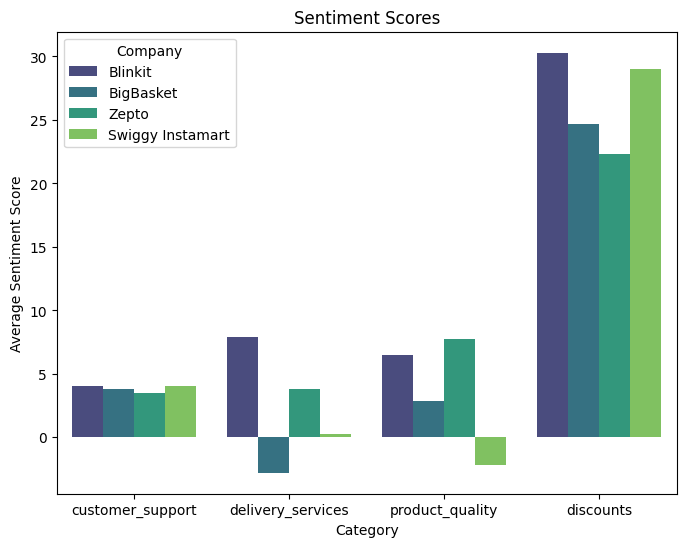

In [1]:
import pandas as pd
import re
import nltk
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.corpus import stopwords, wordnet
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

# Ensure the required NLTK resources are downloaded
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')

# Initialize necessary objects
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()
analyzer = SentimentIntensityAnalyzer()

def remove_emojis(text):
    emoji_pattern = re.compile(
        "["
        u"\U0001F600-\U0001F64F"
        u"\U0001F300-\U0001F5FF"
        u"\U0001F680-\U0001F6FF"
        u"\U0001F700-\U0001F77F"
        u"\U0001F780-\U0001F7FF"
        u"\U0001F800-\U0001F8FF"
        u"\U0001F900-\U0001F9FF"
        u"\U0001FA00-\U0001FA6F"
        u"\U0001FA70-\U0001FAFF"
        u"\U00002702-\U000027B0"
        u"\U000024C2-\U0001F251"
        "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

additional_words_to_remove = set(["blinkit", "zepto", "bigbasket", "swiggy instamart", "zomato", "swiggy","swiggycares","bigbasketcom","dunzo","jiomart",
                             "instamart" ,"dmart","big", "basket","flipkart"])

def data_processing(text):
    text = text.lower()
    text = re.sub(r"https\S+|www\S+https\S+", '', text, flags=re.MULTILINE)
    text = re.sub(r'@\w+', ' ', text)
    text = re.sub(r'[^\w\s#]', '', text)
    text = re.sub(r'#\w+', '', text)
    text = remove_emojis(text)
    text_tokens = word_tokenize(text)

    text_tokens = [w for w in text_tokens if w not in stop_words]
    text_tokens = [w for w in text_tokens if not any(word in w for word in additional_words_to_remove)]
    
    return " ".join(text_tokens)

def get_wordnet_pos(word):
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}
    return tag_dict.get(tag, wordnet.NOUN)

def lemmatization(text):
    words = word_tokenize(text)
    lemmatized_words = [lemmatizer.lemmatize(word, get_wordnet_pos(word)) for word in words]
    return ' '.join(lemmatized_words)

def check_keywords(text, keywords):
    for keyword in keywords:
        if keyword in text:
            return True
    return False

def polarity(text):
    scores = analyzer.polarity_scores(text)
    return scores['compound']

def process_file(file_path):
    df = pd.read_csv(file_path)
    df['processed_text'] = df['text'].apply(data_processing)
    df['processed_text'] = df['processed_text'].apply(lemmatization)

    df = df.dropna(subset=['processed_text'])
    df = df[df['processed_text'].str.strip().astype(bool)]

    return df

def analyze_sentiment(df, keywords):
    sentiments = {}
    for category, words in keywords.items():
        df_category = df[df['processed_text'].apply(lambda x: check_keywords(x, words))]
        df_category = df_category.copy()
        df_category['sentiment'] = df_category['processed_text'].apply(polarity)
        sentiments[category] = df_category['sentiment'].mean() * 100
    return sentiments

keywords = {
    'customer_support': ['customer support', 'support', 'help', 'assistance', 'customer care', 'complaint', 'resolution', 'query', 'live chat', 'support team', 'call center', 'issue','call','money','refund','reply','response','resolve','resolved','email'],
    'delivery_services': ['deliver','hour','minute','delivery','cancel', 'ship', 'arrive', 'courier', 'fast delivery', 'late delivery', 'on-time delivery', 'delivery time', 'delivery service', 'express delivery', 'next day delivery', 'same day delivery', 'contactless delivery','time','receive','quick'],
    'product_quality': ['quality', 'defective', 'satisfied', 'unsatisfied', 'poor', 'excellent', 'high quality', 'low quality', 'durable', 'broken', 'faulty', 'fresh', 'rotten', 'expiry', 'damaged', 'premium quality', 'organic', 'branded','like','dislike','product','return','good quality','bad quality','miss','spolied','spoilt','expire','cold'],
    'discounts': ['discount', 'offer', 'sale', 'promotion', 'deal', 'coupon', 'voucher', 'savings', 'markdown', 'cashback', 'special offer', 'buy one get one', 'limited time offer','price','free','mrp']
}

files = {
    'Blinkit': 'blinkit_tweets.csv',
    'BigBasket': 'bigbasket_tweets.csv',
    'Zepto': 'zepto_tweets.csv',
    'Swiggy Instamart': 'swiggyinstamart_tweets.csv'
}

all_sentiments = {}

for company, file_path in files.items():
    df = process_file(file_path)
    sentiments = analyze_sentiment(df, keywords)
    all_sentiments[company] = sentiments

# Print the score of each company across each category
for company, sentiments in all_sentiments.items():
    print(f"\n{company} Sentiment Scores:")
    for category, score in sentiments.items():
        print(f"{category}: {score:.2f}")

# Convert to DataFrame for plotting
sentiment_df = pd.DataFrame(all_sentiments).reset_index().melt(id_vars='index')
sentiment_df.columns = ['Category', 'Company', 'Average Sentiment']

# Plot the average sentiment scores
plt.figure(figsize=(8,6))
sns.barplot(x='Category', y='Average Sentiment', hue='Company', data=sentiment_df, palette='viridis')
plt.title('Sentiment Scores')
plt.ylabel('Average Sentiment Score')
plt.xlabel('Category')
plt.legend(title='Company')
plt.show()
